# Part I: Supervised Learining 

In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request

In [14]:
#Extract data as an array from the url
link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from file

In [16]:
data.shape

(9298, 257)

## Multiclass Perceptron with Polynomial Kernel

In [18]:
y = data[:,0]
x = data[:,1:]

In [186]:
data.shape

(9298, 257)

In [189]:
#Not sure if I should include bias before computing the Kernel? 
def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def transform_y(y):
    #classes_num = len(y.unique())
    #assuming that training set has all the numbers between min(y) and max(y)
    classes_num = 10
    m = len(y)
    y_matrix = np.ones((m,classes_num))*(-1)
    for i in range(m):
        y_matrix[i,int(y[i])] = 1
    return y_matrix

In [229]:
def perceptron_train(x,y,d=2,kernel_choice='Polynomial'):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    
    errors = np.zeros(m)
    y_arr = transform_y(y) 
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
    
    num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    W = np.zeros((m,classes_num)) #with bias?
    
    #iterate through training set
    for t in range(m):
        if t<1:
            alpha_prev = np.zeros((1,classes_num)) #when t=0, the previous alpha is set to be 0
        else:
            alpha_prev = alpha[t-1,:] #
        
        #find our training set
        x_t = x[t,:] #of size (1,n)
        y_t = y[t]
        y_arr_t = y_arr[t,:] #of size (1,10) 
        
        #pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, which is regarded as the confidence in each class
        pred_t = ((alpha[:t,:].T @K_train[t,:t]).T) 
        y_hat_t = np.where(pred_t==max(pred_t),1,0) #map the confidence to arrays of 1 and 0 for class
        gamma_t = y_arr_t.T @ pred_t
        
        if t%2000==0:
            
            print('t=',t)
            print('label=', y_t)
            print('alpha_t-1',alpha[:t,:])
            print('predicted label=',pred_t.argmax())
            print('prediction=',pred_t)
            print('gamma_t=',gamma_t)

        #if gamma_t < 0.01:
        if pred_t.argmax()!=y_t:
            #print('misclassification:',gamma_t)
            #update the alpha, and weights, for all the classes that not the true class
            num_errors +=1
            
            #since we only want to update the weights related to first t-1 training data.
            #note that alpha_t is np.zeros(10,1), 
            #and alpha_t is updated according to the real class, and the misclassified class.
            #this version is not updated with alpha_prev
            alpha_t = np.where(y_arr_t> 0,1,0) + np.where(y_hat_t>0,-1,0) #(1,10)
            
            #store alpha_t into the matrix for future reference
            alpha[t,:] = alpha_t
            
            #sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
            #reason being weight for one class is of size(m), but we only 'have enough data' to update the first t-1 terms.  
            K_update = np.zeros((1,m))
            K_update[:,:t] = K_train[t,:t] 
            
            #Note that W is a weight matrix of size (m, 10)
            #K_update.T @alpha_t is the update for weight matrix, for every class and every training set that has been reviewed. 
            W = W+ K_update.T @(alpha_t.reshape(1,10)) #(1, 10) * (1,m), want (m,10)
        else:
            W = W #no change
            
        errors[t] = num_errors         
    return W,errors

In [201]:
#Test this function, see if it is working properly
W,errors = perceptron_train(x,y,d=2)

t= 0
label= 6.0
alpha_t-1 []
predicted label= 0
prediction= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gamma_t= 0.0
t= 2000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 32420.28259002 -24795.38978156  -8410.95413708  -9540.17036046
 -11847.12099483  13132.14273948  -6723.1843047    9958.91752387
 -14456.42987656 -33832.29405674]
gamma_t= 118934.76583860214
t= 4000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 76731.16826604 -29541.74583634  -6451.54190592 -39090.19006244
 -30587.75356451   2051.75521891 -45920.22043097 -12020.30113739
    516.91317352 -48432.94860693]
gamma_t= 286207.2014180918
t= 6000


In [197]:
#Plot number of misclassfication versus the number of training sets reviewed. 
ratio = errors/np.arange(1,x.shape[0]+1)

Text(0.5, 1.0, 'Proportion of misclassified data points out of data points reviewed')

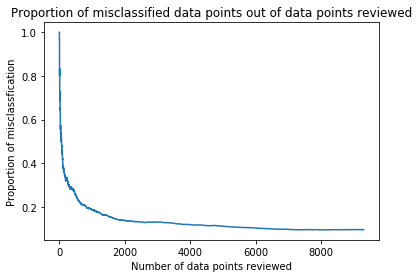

In [198]:
plt.plot(ratio)
plt.ylabel('Proportion of misclassfication')
plt.xlabel('Number of data points reviewed')
plt.title('Proportion of misclassified data points out of data points reviewed')

# Q1 - Basic Results

In [206]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

def allocate_training_test_sets(data,r =1/5):
    X= data[:,0:-1]
    y= data[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

In [207]:
## To be filled in
def perceptron_test(x_test,x_train,y_test,W,d):
    m = x_test.shape[0] #number of examples
    n = x_test.shape[1] #number of features
    classes_num = 10 #number of classes 
    
    ### need to find out how this thing is tested. 

In [ ]:
d_arr = np.arange(1,8)
for d in d_arr:
    for i in range(20):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
        W,train_errors = perceptron_train(X_train,y_train,d)
        test_error = perceptron_test(X_test,X_train, y_test,W,d)

# Q2 - Cross Validation

Having already allocated x_train, now perform cross validation on x_train

In [204]:
def cross_validation(matrix,d_values,k=5):
    #np.random.shuffle(matrix)
    kf = KFold(n_splits=k)
    MSE_cv_arr = np.zeros(k)
    
    for train_index, cv_index in kf.split(matrix):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        matrix_train, matrix_cv = matrix[train_index], matrix[cv_index]

        X_train = matrix_train[:,0:-1]
        X_cv = matrix_cv[:,0:-1]
        y_train = matrix_train[:,-1] 
        y_cv = matrix_cv[:,-1]

        # We are only interested in the alphas and not the MSE on the training set
        W,errors = perceptron_train(X_train, y_train, d)
        MSE_cv = perceptron_test(X_cv,X_train,y_cv,W,d)
        MSE_cv_arr[i] = MSE_cv
        i += 1
        
        return MSE_cv_arr.mean(), (MSE_cv_arr.var())**(1/2)

In [ ]:
MSE_CV_means = np.zeros((len(d_values),20))
MSE_CV_stds = np.zeros((len(d_values),20))
#np.random.shuffle(matrix)

for i in range(len(d_values)):
    for j in range(20):
        MSE_CV_mean, MSE_CV_std = cross_validation(data,d_values[i],k=5)
        MSE_CV_means [i,j] = MSE_CV_mean
        MSE_CV_stds [i,j] = MSE_CV_std        

In [ ]:
#Then this step you select the best performing d values, d_star.
#for example, the one with the lowest average mean, and average standard deviation. 

# Q3 - Confusion Matrix

In [ ]:
#Might need to use pandas for it

# Q4 - Hardest numbers to predict

# Q5 - Gaussian Kernel

In [230]:
def pairwise_distance_single(X): # distances of X training data, single X matrix
    m =X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    K = np.exp(-c*distances_sq)
    return K

In [226]:
#Train with Gaussian Kernel
Wt,train_errorst = perceptron_train(x,y,d,kernel_choice='Gaussian')

t= 0
label= 6.0
alpha_t-1 []
predicted label= 0
prediction= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gamma_t= 0.0
t= 2000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 2.65827827e-31 -1.31022204e-48  2.84360679e-37 -1.50853874e-34
 -1.66918465e-40  3.59497565e-43  1.87382962e-38 -1.16290401e-42
 -2.65677277e-31  4.96633451e-46]
gamma_t= 5.3165565497897784e-31
t= 4000
label= 0.0
alpha_t-1 [[-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
predicted label= 0
prediction= [ 2.80539063e-22 -8.70231539e-39 -1.10615619e-38 -9.78799230e-39
 -1.18839710e-37 -8.80437045e-39 -3.84603424e-27 -8.70231487e-39
 -2.80535207e-22 -9.61730222e-30]
gamma_t= 5.610781251168945e-22


In [ ]:
#Test with Gaussian Kernel
d_arr = np.arange(1,8)
for d in d_arr:
    for i in range(20):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
        W,train_errors = perceptron_train(X_train,y_train,d,kernel_choice='Gaussian')
        test_error = perceptron_test(X_test,X_train, y_test,W,d,kernel_choice='Gaussian')

In [ ]:
#Cross Validation with Gaussian Kernel, find c_star
d_arr = np.arange(1,8)
for d in d_arr:
    for i in range(20):
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
        W,train_errors = perceptron_train(X_train,y_train,d)
        test_error = perceptron_test(X_test,X_train, y_test,W,d)

# Q6 - Choose an alternative method to generalise k-classes

# Q7 - Choose two more algorithms to compare

In [ ]:
#Maybe neural network (pytorch) and 